# Linear Regression (Project 6)

In [493]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import random
from sklearn.model_selection import train_test_split

In [494]:
data = pd.read_csv("RRCA_baseflow.csv")
data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689
...,...,...,...,...,...,...,...,...
15586,721810,98,721870,14387040,0.00,0.00,0.0,0.298500
15587,721841,98,721870,14387040,0.00,0.00,0.0,0.211475
15588,721871,98,721870,14387040,0.00,0.00,0.0,0.122951
15589,721902,98,721870,14387040,0.00,0.00,0.0,0.120000


##### Subtracting 693963 from Data column

In [495]:
data["Date"] = data["Date"] - 693963

In [496]:
data = data.dropna()
data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,16769,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,16800,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,16828,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,16859,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,16889,144,1086190,14476800,8.23,29.63,0.0,3.728689
...,...,...,...,...,...,...,...,...
15586,27847,98,721870,14387040,0.00,0.00,0.0,0.298500
15587,27878,98,721870,14387040,0.00,0.00,0.0,0.211475
15588,27908,98,721870,14387040,0.00,0.00,0.0,0.122951
15589,27939,98,721870,14387040,0.00,0.00,0.0,0.120000


c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Location')

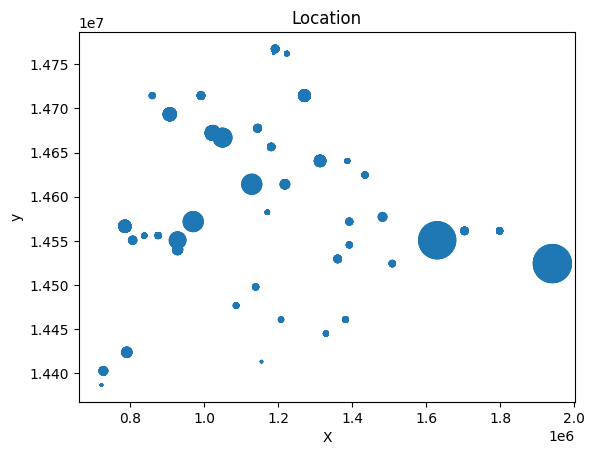

In [497]:
plt.scatter(x="x", y="y", data=data, s=data["Observed"])
plt.xlabel("X")
plt.ylabel("y")
plt.title("Location")

Text(0.5, 1.0, 'Observed Baseflow over Time')

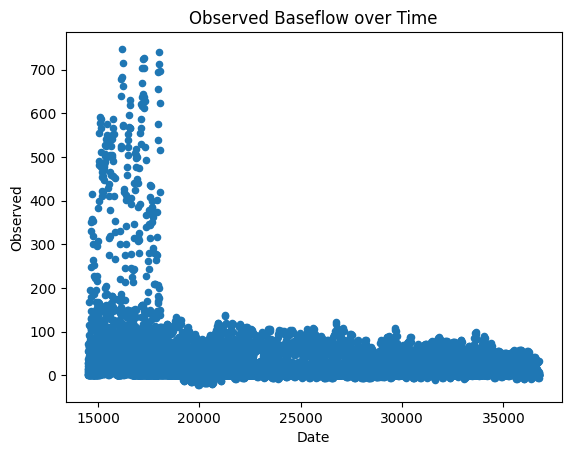

In [498]:
data.plot(kind="scatter", x="Date", y="Observed")
plt.title("Observed Baseflow over Time")

In [499]:
segments = data["Segment_id"].unique()
segments

array([144, 154, 176, 171, 152,  55, 118,  65,  64,  63,  40, 135,  53,
       123, 157, 147, 170, 136, 149,  60, 188, 194, 239, 256, 205,  59,
       148, 138,  62,  96, 178, 186, 159, 130,  97,  51, 145, 196, 146,
       189,  56,  98], dtype=int64)

Text(0.5, 1.0, 'Evapotranspiration vs Observed baseflow')

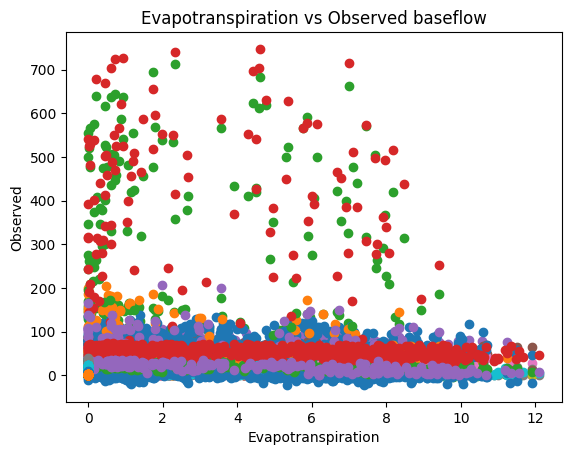

In [500]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].Evapotranspiration, y=data[data.Segment_id == seg].Observed)
plt.xlabel("Evapotranspiration")
plt.ylabel("Observed")
plt.title("Evapotranspiration vs Observed baseflow")    

Text(0.5, 1.0, 'Precipitation vs Observed baseflow')

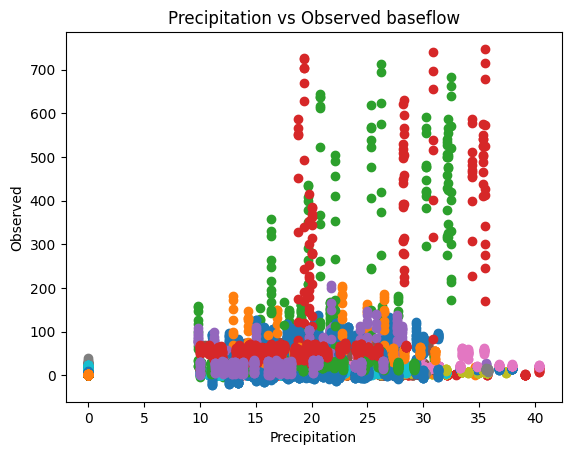

In [501]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].Precipitation, y=data[data.Segment_id == seg].Observed)
plt.xlabel("Precipitation")
plt.ylabel("Observed")
plt.title("Precipitation vs Observed baseflow")

Text(0.5, 1.0, 'Irrigation_pumping vs baseflow')

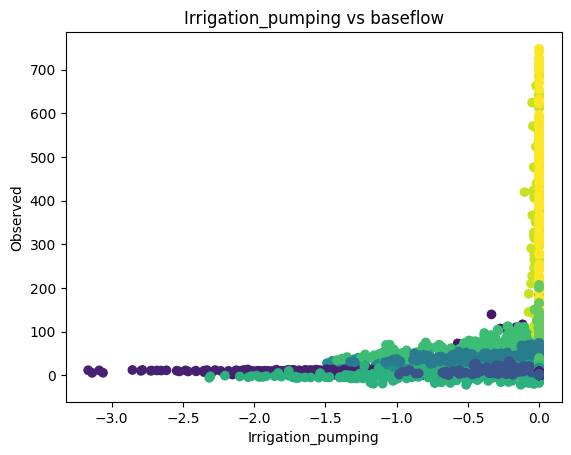

In [502]:
plt.scatter(x="Irrigation_pumping", y="Observed", data=data, c=data.Segment_id)
plt.xlabel("Irrigation_pumping")
plt.ylabel("Observed")
plt.title("Irrigation_pumping vs baseflow")

Text(0.5, 1.0, 'Irrigation_pumping over time')

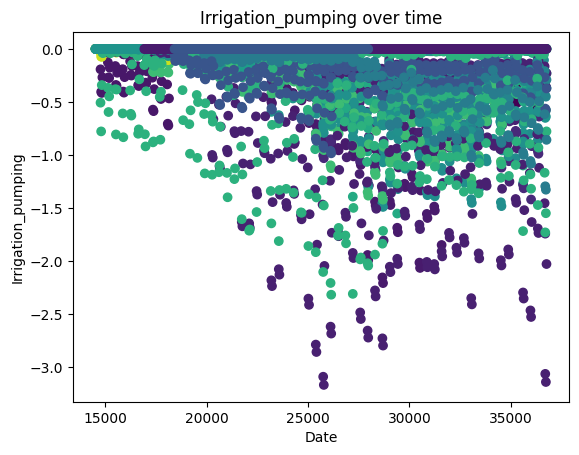

In [503]:
plt.scatter(x="Date", y="Irrigation_pumping", data=data, c=data.Segment_id)
plt.xlabel("Date")
plt.ylabel("Irrigation_pumping")
plt.title("Irrigation_pumping over time")

#### Looks pumping increased over the time

#### Seed defined to have the same result from selection in every runs

In [504]:
random_seed = 5
random.seed(random_seed)

### Randomly selected segments to check out the correlations instead of checking all the segments

In [505]:
random_segments = random.sample(list(segments), 12)

#### Check if there is any correlation between randomly selected segments in Evapotranspiration vs observed baseflow

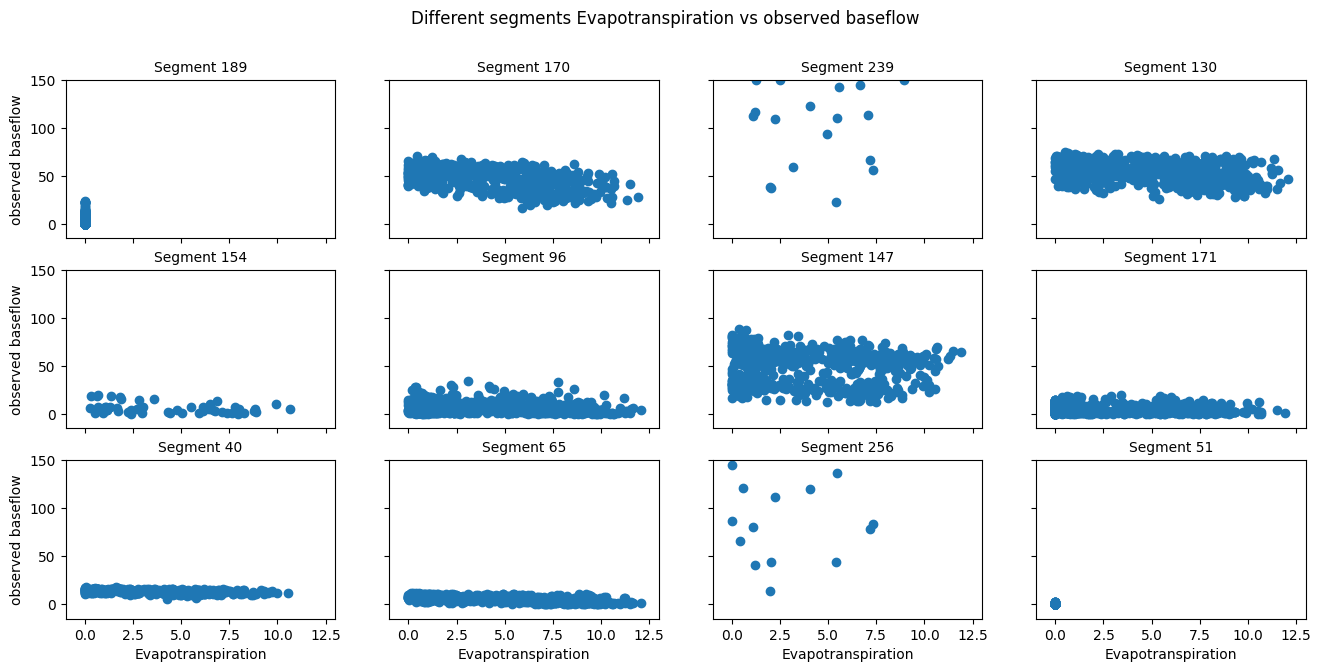

In [506]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7))
j = 0
k = 0
for seg in (random_segments):
    axs[j, k].scatter(x=data[data.Segment_id == seg].Evapotranspiration, y=data[data.Segment_id == seg].Observed)
    axs[j, k].set_title(f"Segment {seg}", fontsize=10)
    axs[j, k].set_xlim(-1, 13)
    axs[j, k].set_ylim(-15, 150)
    k += 1
    if k == 4:
        j += 1
        k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Evapotranspiration", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Evapotranspiration vs observed baseflow")
plt.show()

##### Sounds by increasing Evapotranspiration the baseflow decreases (very weak negative correlation)

#### Check if there is any correlation between randomly selected segments in Irrigation_pumping vs observed baseflow

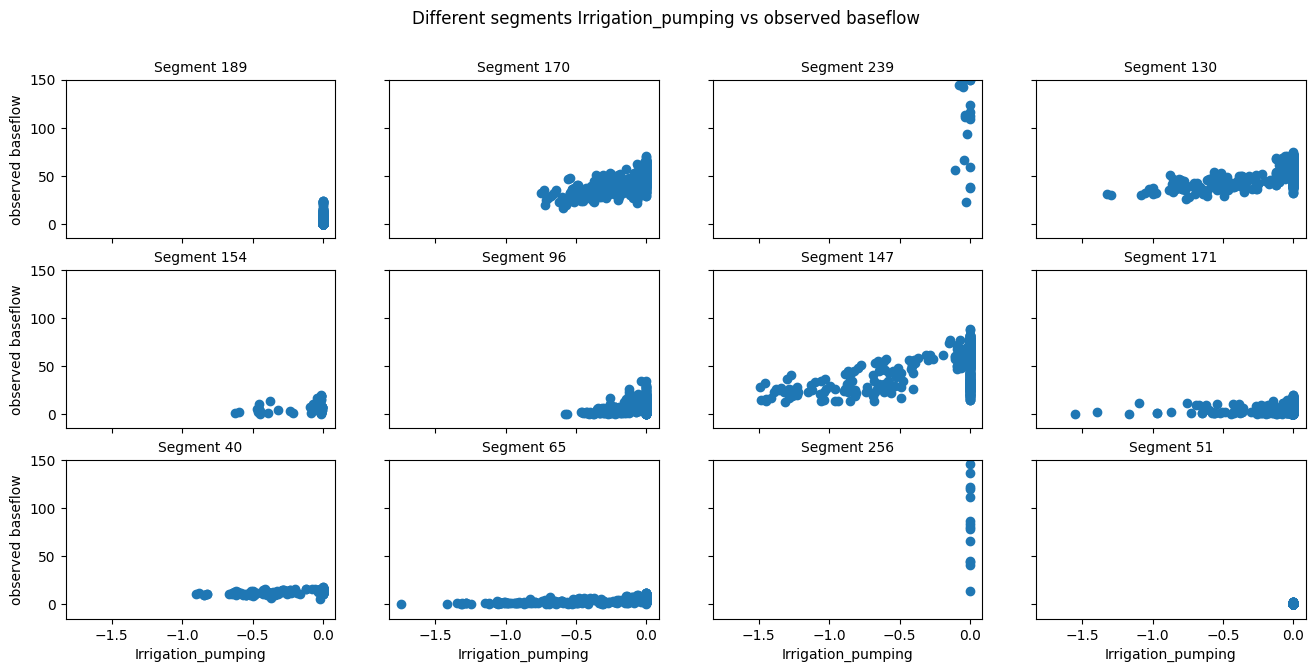

In [507]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7), sharex=True, sharey=True)
j = 0
k = 0
for seg in (random_segments):
    axs[j, k].scatter(x=data[data.Segment_id == seg].Irrigation_pumping, y=data[data.Segment_id == seg].Observed)
    axs[j, k].set_title(f"Segment {seg}", fontsize=10)
    # axs[j, k].set_xlim(-5, 1)
    axs[j, k].set_ylim(-15, 150)
    k += 1
    if k == 4:
        j += 1
        k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Irrigation_pumping", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Irrigation_pumping vs observed baseflow")
plt.show()

#### Sounds by increasing (negative value means pumping out here means increasing pumping) irrigation pumping the basefolw decreases

#### Check if there is any correlation between randomly selected segments in Precipitation vs observed baseflow

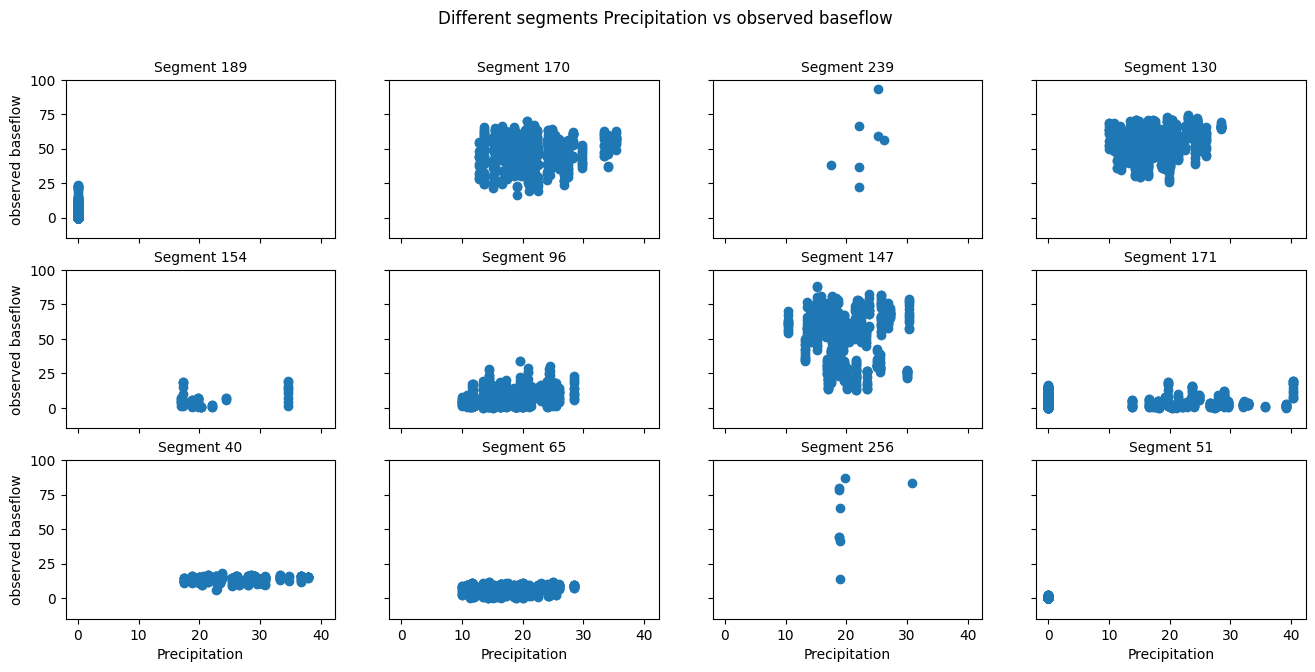

In [508]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7), sharex=True, sharey=True)
j = 0
k = 0
for seg in (random_segments):
    axs[j, k].scatter(x=data[data.Segment_id == seg].Precipitation, y=data[data.Segment_id == seg].Observed)
    axs[j, k].set_title(f"Segment {seg}", fontsize=10)
    axs[j, k].set_ylim(-15, 100)
    k += 1
    if k == 4:
        j += 1
        k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Precipitation", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Precipitation vs observed baseflow")
plt.show()

#### It doesn't look to have any correlation between Precipitation and baseflow

### Applying train & test Split

In [509]:
data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,16769,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,16800,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,16828,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,16859,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,16889,144,1086190,14476800,8.23,29.63,0.0,3.728689
...,...,...,...,...,...,...,...,...
15586,27847,98,721870,14387040,0.00,0.00,0.0,0.298500
15587,27878,98,721870,14387040,0.00,0.00,0.0,0.211475
15588,27908,98,721870,14387040,0.00,0.00,0.0,0.122951
15589,27939,98,721870,14387040,0.00,0.00,0.0,0.120000


In [510]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Observed"]), data[["Observed"]], test_size=0.2)

In [511]:
from statsmodels.api import OLS, add_constant
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Observed"]), data[["Observed"]], test_size=0.2)
model = OLS(endog=y_train, exog=X_train)
results = model.fit()

pred = results.predict(X_test)

error = lambda x, y: abs(x - y).mean()
error(pred, y_test)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Observed   R-squared (uncentered):                   0.349
Model:                            OLS   Adj. R-squared (uncentered):              0.349
Method:                 Least Squares   F-statistic:                              956.3
Date:                Mon, 11 Mar 2024   Prob (F-statistic):                        0.00
Time:                        01:12:33   Log-Likelihood:                         -66495.
No. Observations:               12472   AIC:                                  1.330e+05
Df Residuals:                   12465   BIC:                                  1.331e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Date                  -0.0017   7.47e-05    -22.692      0.000      -0.002      -0.002
Segment_id             0.3426      0.009     38.732      0.000       0.325       0.360
x                   4.622e-06   1.61e-06      2.864      0.004    1.46e-06    7.78e-06
y                  -2.631e-07   1.95e-07     -1.348      0.178   -6.46e-07    1.19e-07
Evapotranspiration    -0.8851      0.182     -4.863      0.000      -1.242      -0.528
Precipitation          1.6560      0.048     34.851      0.000       1.563       1.749
Irrigation_pumping     3.6094      1.933      1.867      0.062      -0.179       7.398
==============================================================================
Omnibus:                    14490.242   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1674326.501
Skew:                           6.132   Prob(JB):                         0.00
Kurtosis:                      58.421   Cond. No.                     6.31e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [512]:
sum_result = 0
errors = []
# X_train = X_train.drop(["Date", "x", "y"], axis=1)
# X_test = X_test.drop(["Date", "x", "y"], axis=1)
X_train["Observed"] = y_train["Observed"]
display(X_train)
for seg in data.Segment_id.unique():
    df_x = X_train[X_train.Segment_id == seg].copy()
    df_x = df_x.drop("Segment_id", axis=1)
    df_y = y_train.loc[df_x.index.to_list()]

    # model = OLS(endog=df_y, exog=df_x)
    # model = OLS(endog=data[data["Segment_id"] == seg].Observed, exog=data[data["Segment_id"] == seg].drop(columns=["Observed", "x", "y", "Date"]))
    lm = smf.ols(formula="Observed ~ Irrigation_pumping + Precipitation + Evapotranspiration + C(Segment_id)", data=X_train[X_train["Segment_id"] == seg]).fit()
    # results = lm.fit()

    df_x = X_test[X_test.Segment_id == seg].copy()
    df_x = df_x.drop("Segment_id", axis=1)
    df_y = y_test.loc[df_x.index.to_list()]

    # pred = results.predict(df_x)

    error = lambda x, y: abs(x - y).mean()
    errors.append({"segment_id": seg, "error": error(pred, df_y)})

    sum_result += results.rsquared
    # lm = smf.ols(formula="Observed ~ Irrigation_pumping + Precipitation + Evapotranspiration + Date + Segment_id", data=data[data["Segment_id"] == seg]).fit()
    # display(results.rsquared)
    # display(lm.params)
    display(lm.rsquared)
# display(sum_result/42)
# display(lm.summary())

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
11380,25566,51,1154830,14413440,0.00,0.00,0.000000,0.000000
1920,31775,65,838030,14556000,0.71,15.08,0.000000,7.063226
1088,25594,55,1133710,14619360,1.22,14.88,-0.004286,1.986271
2792,33205,40,1798990,14561280,0.38,30.15,0.000000,11.743387
11294,22947,51,1154830,14413440,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3365,16159,157,1022830,14672160,0.00,21.69,0.000000,101.052459
1657,23587,65,838030,14556000,8.30,11.77,-0.307370,0.660000
13137,32960,146,1329070,14445120,0.00,0.00,0.000000,3.561017
10458,20390,130,785230,14566560,0.88,11.88,0.000000,63.872951


0.037947283675308086

0.1639883686996353

0.6016370803134321

0.05479485669775441

0.4230529300908149

0.11158211577483879

0.22998265620576486

0.4972388163944542

0.18185604330174032

0.45911010744441527

0.38025202335272834

0.37254553499665066

0.11495135574751458

0.9626927921460181

0.5080504713590249

0.21879217447198196

0.4477921713356535

0.6668687371351059

0.22135543839692418

0.5150521523196806

0.3403135199931583

0.585187477482413

0.2899944756073478

0.1481564406227568

0.2204630213129869

0.1756569497522339

0.23177916810612342

0.08894016683521144

0.3567582423737591

0.11951760971726033

0.22212571668227687

0.2107599554012929

0.21816548408118086

0.334117532059633

0.723881212715416

1.1102230246251565e-16

1.1102230246251565e-16

-2.220446049250313e-16

2.220446049250313e-16

-4.440892098500626e-16

0.0

0.0

In [519]:
# for seg in data.Segment_id.unique():
    # df_x = X_train[X_train.Segment_id == seg].copy()
    # df_x = df_x.drop("Segment_id", axis=1)
    # df_y = y_train.loc[df_x.index.to_list()]

    # model = OLS(endog=df_y, exog=df_x)
    # results = model.fit()

    # df_x = X_test[X_test.Segment_id == seg].copy()
    # df_x = df_x.drop("Segment_id", axis=1)
    # df_y = y_test.loc[df_x.index.to_list()]

    # pred = results.predict(df_x)

    # error = lambda x, y: abs(x - y).mean()
    # errors.append({"segment_id": seg, "error": error(pred, df_y)})

    # sum_result += results.rsquared
# lm = smf.ols(formula="Observed ~ C(Segment_id) + Date + Precipitation + Evapotranspiration + Irrigation_pumping + x + y", data=data).fit()
lm = smf.ols(formula="Observed ~ C(Segment_id) + C(Segment_id)*Date + C(Segment_id)*Precipitation + C(Segment_id)*Evapotranspiration + C(Segment_id)*Irrigation_pumping + C(Segment_id)*x + C(Segment_id)*y", data=data).fit()
    # lm = smf.ols(formula="Observed ~ Irrigation_pumping + Precipitation + Evapotranspiration + Date + Segment_id", data=data[data["Segment_id"] == seg]).fit()
display(lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     517.8
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:15:19   Log-Likelihood:                -69404.
No. Observations:               15591   AIC:                         1.392e+05
Df Residuals:                   15401   BIC:                         1.406e+05
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                2.653e-08   3.07e-08      0.864      0.388   -3.37e-08    8.68e-08
C(Segment_id)[T.51]                     -2.309e-07    2.4e-08     -9.612      0.000   -2.78e-07   -1.84e-07
C(Segment_id)[T.53]                      2.716e-07   4.23e-08      6.423      0.000    1.89e-07    3.54e-07
C(Segment_id)[T.55]                      -1.18e-06    1.3e-07     -9.042      0.000   -1.44e-06   -9.24e-07
C(Segment_id)[T.56]                      4.959e-07   6.42e-08      7.718      0.000     3.7e-07    6.22e-07
C(Segment_id)[T.59]                       2.73e-07   3.09e-08      8.846      0.000    2.12e-07    3.33e-07
C(Segment_id)[T.60]                      -5.15e-07   6.24e-08     -8.252      0.000   -6.37e-07   -3.93e-07
C(Segment_id)[T.62]                      2.396e-09   3.41e-08      0.070      0.944   -6.44e-08    6.92e-08
C(Segment_id)[T.63]                      2.972e-07   4.33e-08      6.865      0.000    2.12e-07    3.82e-07
C(Segment_id)[T.64]                      3.951e-07    4.9e-08      8.067      0.000    2.99e-07    4.91e-07
C(Segment_id)[T.65]                      6.036e-07   6.39e-08      9.445      0.000    4.78e-07    7.29e-07
C(Segment_id)[T.96]                     -7.352e-07   8.21e-08     -8.954      0.000   -8.96e-07   -5.74e-07
C(Segment_id)[T.97]                     -6.026e-07   6.09e-08     -9.898      0.000   -7.22e-07   -4.83e-07
C(Segment_id)[T.98]                      -5.12e-07   5.37e-08     -9.525      0.000   -6.17e-07   -4.07e-07
C(Segment_id)[T.118]                     6.782e-07   7.88e-08      8.608      0.000    5.24e-07    8.33e-07
C(Segment_id)[T.123]                     1.512e-07   4.41e-08      3.430      0.001    6.48e-08    2.38e-07
C(Segment_id)[T.130]                     2.642e-07   4.05e-08      6.528      0.000    1.85e-07    3.44e-07
C(Segment_id)[T.135]                    -3.862e-07   4.08e-08     -9.463      0.000   -4.66e-07   -3.06e-07
C(Segment_id)[T.136]                      4.23e-07   5.43e-08      7.794      0.000    3.17e-07    5.29e-07
C(Segment_id)[T.138]                    -6.624e-07   7.88e-08     -8.404      0.000   -8.17e-07   -5.08e-07
C(Segment_id)[T.144]                     3.832e-07   3.88e-08      9.875      0.000    3.07e-07    4.59e-07
C(Segment_id)[T.145]                     3.037e-07   4.78e-08      6.353      0.000     2.1e-07    3.97e-07
C(Segment_id)[T.146]                     2.875e-07   4.45e-08      6.456      0.000       2e-07    3.75e-07
C(Segment_id)[T.147]                      4.73e-07    6.1e-08      7.751      0.000    3.53e-07    5.93e-07
C(Segment_id)[T.148]                    -5.467e-07   5.69e-08     -9.610      0.000   -6.58e-07   -4.35e-07
C(Segment_id)[T.149]                     1.978e-07   2.58e-

In [520]:
lm = smf.ols(formula="Observed ~ C(Segment_id) + C(Segment_id)*Date + C(Segment_id)*Precipitation + C(Segment_id)*Irrigation_pumping + C(Segment_id)*x + C(Segment_id)*y", data=data).fit()
    # lm = smf.ols(formula="Observed ~ Irrigation_pumping + Precipitation + Evapotranspiration + Date + Segment_id", data=data[data["Segment_id"] == seg]).fit()
display(lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     630.4
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:20:27   Log-Likelihood:                -69473.
No. Observations:               15591   AIC:                         1.393e+05
Df Residuals:                   15436   BIC:                         1.404e+05
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                1.598e-10   8.11e-10      0.197      0.844   -1.43e-09    1.75e-09
C(Segment_id)[T.51]                       -1.6e-07   1.43e-08    -11.209      0.000   -1.88e-07   -1.32e-07
C(Segment_id)[T.53]                     -7.171e-08    1.3e-08     -5.519      0.000   -9.72e-08   -4.62e-08
C(Segment_id)[T.55]                      1.404e-07   6.91e-08      2.033      0.042    5.02e-09    2.76e-07
C(Segment_id)[T.56]                      4.903e-07   4.16e-08     11.776      0.000    4.09e-07    5.72e-07
C(Segment_id)[T.59]                     -6.866e-07   4.61e-08    -14.879      0.000   -7.77e-07   -5.96e-07
C(Segment_id)[T.60]                      1.053e-07   1.31e-08      8.020      0.000    7.96e-08    1.31e-07
C(Segment_id)[T.62]                      3.712e-08   5.74e-09      6.468      0.000    2.59e-08    4.84e-08
C(Segment_id)[T.63]                     -1.415e-07   4.49e-08     -3.147      0.002    -2.3e-07   -5.34e-08
C(Segment_id)[T.64]                     -6.394e-07   4.31e-08    -14.849      0.000   -7.24e-07   -5.55e-07
C(Segment_id)[T.65]                     -4.857e-07   4.04e-08    -12.023      0.000   -5.65e-07   -4.06e-07
C(Segment_id)[T.96]                      4.543e-07   4.99e-08      9.107      0.000    3.56e-07    5.52e-07
C(Segment_id)[T.97]                      8.455e-07   7.23e-08     11.702      0.000    7.04e-07    9.87e-07
C(Segment_id)[T.98]                     -1.158e-07   6.78e-08     -1.708      0.088   -2.49e-07    1.71e-08
C(Segment_id)[T.118]                     6.212e-07   5.65e-08     10.991      0.000     5.1e-07    7.32e-07
C(Segment_id)[T.123]                     1.677e-07   1.27e-08     13.213      0.000    1.43e-07    1.93e-07
C(Segment_id)[T.130]                     5.675e-08   2.26e-08      2.510      0.012    1.24e-08    1.01e-07
C(Segment_id)[T.135]                    -3.086e-07   2.84e-08    -10.856      0.000   -3.64e-07   -2.53e-07
C(Segment_id)[T.136]                    -9.193e-08   2.06e-08     -4.464      0.000   -1.32e-07   -5.16e-08
C(Segment_id)[T.138]                      2.03e-09   8.05e-09      0.252      0.801   -1.38e-08    1.78e-08
C(Segment_id)[T.144]                     3.622e-07   3.77e-08      9.598      0.000    2.88e-07    4.36e-07
C(Segment_id)[T.145]                     2.931e-07   5.84e-08      5.017      0.000    1.79e-07    4.08e-07
C(Segment_id)[T.146]                    -2.627e-08   3.07e-08     -0.857      0.391   -8.64e-08    3.38e-08
C(Segment_id)[T.147]                    -4.257e-07   3.01e-08    -14.151      0.000   -4.85e-07   -3.67e-07
C(Segment_id)[T.148]                     1.184e-07   3.63e-08      3.264      0.001    4.73e-08     1.9e-07
C(Segment_id)[T.149]                    -2.112e-07   2.11e-